In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import rpy2.robjects as robjects
import statsmodels.api as sm
from statsmodels.formula.api import ols
from astsadata import *
import warnings

/Users/juancamilopico/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


## 1. Cargar datos

In [2]:
data_full = pd.read_csv("time_series_60min_singleindex.csv")
data = data_full[['utc_timestamp','AT_load_actual_entsoe_transparency']][40000:].copy()
data.head()

,utc_timestamp,AT_load_actual_entsoe_transparency
40000,2019-07-25T15:00:00Z,8172.0
40001,2019-07-25T16:00:00Z,8107.0
40002,2019-07-25T17:00:00Z,7781.0
40003,2019-07-25T18:00:00Z,7436.0
40004,2019-07-25T19:00:00Z,7219.0


In [3]:
data.shape

(10401, 2)

1.1. Formato correcto

In [4]:
data[['utc_timestamp']] = data[['utc_timestamp']].apply(pd.to_datetime)
data['local_timestamp'] = data['utc_timestamp'].dt.tz_convert('Europe/Vienna')
data.head()

,utc_timestamp,AT_load_actual_entsoe_transparency,local_timestamp
40000,2019-07-25 15:00:00+00:00,8172.0,2019-07-25 17:00:00+02:00
40001,2019-07-25 16:00:00+00:00,8107.0,2019-07-25 18:00:00+02:00
40002,2019-07-25 17:00:00+00:00,7781.0,2019-07-25 19:00:00+02:00
40003,2019-07-25 18:00:00+00:00,7436.0,2019-07-25 20:00:00+02:00
40004,2019-07-25 19:00:00+00:00,7219.0,2019-07-25 21:00:00+02:00


1.2. Quitar datos nulos

In [5]:
data = data.dropna()
data.shape

(10401, 3)

1.3. Convertir la fecha en el index de la serie

In [6]:
data.index = data["local_timestamp"]
data.drop(columns=['utc_timestamp', 'local_timestamp'], inplace=True)
data.head()

,AT_load_actual_entsoe_transparency
local_timestamp,
2019-07-25 17:00:00+02:00,8172.0
2019-07-25 18:00:00+02:00,8107.0
2019-07-25 19:00:00+02:00,7781.0
2019-07-25 20:00:00+02:00,7436.0
2019-07-25 21:00:00+02:00,7219.0


## 3. Modelo 

In [7]:
model = sm.tsa.SARIMAX(data, order = (1,1,2),seasonal_order=(2, 1, 2, 24)).fit() # SARIMA(1,0,0)
model.summary()

/Users/juancamilopico/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/juancamilopico/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:     AT_load_actual_entsoe_transparency   No. Observations:                10401
Model:                 SARIMAX(1, 1, 2)x(2, 1, 2, 24)   Log Likelihood              -60973.859
Date:                                Thu, 08 Dec 2022   AIC                         121963.718
Time:                                        15:33:57   BIC                         122021.696
Sample:                                             0   HQIC                        121983.307
                                              - 10401                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2013      0.019     10.530      0.000       0.164       0.239
ma.L1          0.5906      0.020     29.480      0.000       0.551       0.630
ma.L2          0.3179      0.015     21.571      0.000       0.289       0.347
ar.S.L24       0.9718      0.011     91.173      0.000       0.951       0.993
ar.S.L48      -0.5102      0.007    -69.746      0.000      -0.525      -0.496
ma.S.L24      -1.5348      0.012   -124.322      0.000      -1.559      -1.511
ma.S.L48       0.6932      0.011     63.316      0.000       0.672       0.715
sigma2      7415.9317     66.371    111.734      0.000    7285.846    7546.017
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5243.07
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

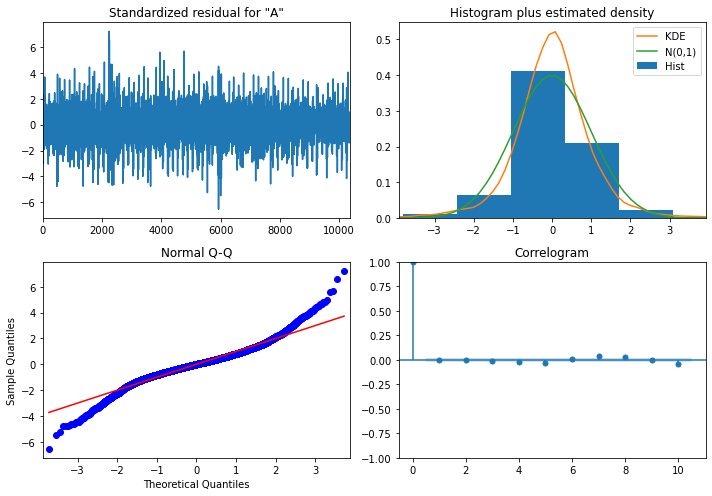

In [8]:
fig = model.plot_diagnostics(figsize=(10, 7))
fig.tight_layout()
plt.show()

## 4. Predicción 

In [9]:
from pandas.tseries.offsets import DateOffset
pred_date=[data.index[-1] + DateOffset(hours=x)for x in range(0,25)]

In [10]:
data_pred = data.copy()
data_pred["forecast"] = np.nan
pred_date=pd.DataFrame(index=pred_date[1:],columns=data.columns)

In [11]:
data_pred=pd.concat([data_pred,pred_date])

In [12]:
forecast = model.get_prediction(start = len(data), end = len(data)+23)
forecast_mean = forecast.predicted_mean
forecast_U = forecast.predicted_mean + forecast.se_mean
forecast_L = forecast.predicted_mean - forecast.se_mean
forecast_mean.index = pred_date.index
forecast_U.index = pred_date.index
forecast_L.index = pred_date.index

/Users/juancamilopico/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [13]:
data_pred['forecast'] = forecast_mean
data_pred['Upper bound'] = forecast_U
data_pred['Lower bound'] = forecast_L

In [16]:
data_pred.to_csv("datos_forecast.csv")

In [39]:
prueba = pd.read_csv("datos_forecast.csv")
prueba.head()

,Unnamed: 0,AT_load_actual_entsoe_transparency,forecast,Upper bound,Lower bound
0,2019-07-25 17:00:00+02:00,8172.0,NaN,NaN,NaN
1,2019-07-25 18:00:00+02:00,8107.0,NaN,NaN,NaN
2,2019-07-25 19:00:00+02:00,7781.0,NaN,NaN,NaN
3,2019-07-25 20:00:00+02:00,7436.0,NaN,NaN,NaN
4,2019-07-25 21:00:00+02:00,7219.0,NaN,NaN,NaN


In [46]:
prueba['Unnamed: 0'] = pd.to_datetime(prueba['Unnamed: 0'], utc=True).dt.tz_convert('Europe/Vienna')
prueba.head()

,Unnamed: 0,AT_load_actual_entsoe_transparency,forecast,Upper bound,Lower bound
0,2019-07-25 17:00:00+02:00,8172.0,NaN,NaN,NaN
1,2019-07-25 18:00:00+02:00,8107.0,NaN,NaN,NaN
2,2019-07-25 19:00:00+02:00,7781.0,NaN,NaN,NaN
3,2019-07-25 20:00:00+02:00,7436.0,NaN,NaN,NaN
4,2019-07-25 21:00:00+02:00,7219.0,NaN,NaN,NaN


In [47]:
prueba.index = prueba['Unnamed: 0']
prueba.drop(columns=['Unnamed: 0'], inplace=True)

In [50]:
prueba

,AT_load_actual_entsoe_transparency,forecast,Upper bound,Lower bound
Unnamed: 0,,,,
2019-07-25 17:00:00+02:00,8172.0,NaN,NaN,NaN
2019-07-25 18:00:00+02:00,8107.0,NaN,NaN,NaN
2019-07-25 19:00:00+02:00,7781.0,NaN,NaN,NaN
2019-07-25 20:00:00+02:00,7436.0,NaN,NaN,NaN
2019-07-25 21:00:00+02:00,7219.0,NaN,NaN,NaN
...,...,...,...,...
2020-10-01 21:00:00+02:00,NaN,6700.519470,7588.368261,5812.670679
2020-10-01 22:00:00+02:00,NaN,6434.272970,7345.658755,5522.887185
2020-10-01 23:00:00+02:00,NaN,6034.757682,6969.087721,5100.427642


In [45]:
import plotly.graph_objs as go

data_plot = data_pred.loc['2020-09-28':]
fig = go.Figure([
    go.Scatter(
        name='Demanda energética',
        x=data_plot.index,
        y=data_plot['AT_load_actual_entsoe_transparency'],
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    ),
    go.Scatter(
        name='Proyección',
        x=data_plot.index,
        y=data_plot['forecast'],
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    ),
    go.Scatter(
        name='Upper Bound',
        x=data_plot.index,
        y=data_plot['Upper bound'],
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Lower Bound',
        x=data_plot.index,
        y=data_plot['Lower bound'],
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=False
    )
])
fig.update_layout(
    yaxis_title='Wind speed (m/s)',
    title='Continuous, variable value error bars',
    hovermode="x"
)
fig.show()

Para cargar el modelo:

In [49]:
import statsmodels as sm

In [50]:
model2 = sm.tsa.statespace.sarimax.SARIMAXResults.load("SARIMA11221224.pkl")